In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# change default display settings
pd.options.display.min_rows = 50
pd.options.display.max_columns = 20
pd.options.display.precision = 3

In [2]:
# create variable for file to be read
file = "Superstore Sales Dataset.csv"

In [3]:
# reading the file and display the frist 5 rows of the dataset
data = pd.read_csv(file, parse_dates=["Order Date", "Ship Date"], dayfirst=True)
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.940
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.577
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368


In [4]:
# understand the data types and check for missing values in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [5]:
# create a new DF for processing & display 1st 5 rows
df = data[["Ship Date", "Customer ID", "Order ID", "Sales"]]
df.head()

,Ship Date,Customer ID,Order ID,Sales
0,2017-11-11,CG-12520,CA-2017-152156,261.960
1,2017-11-11,CG-12520,CA-2017-152156,731.940
2,2017-06-16,DV-13045,CA-2017-138688,14.620
3,2016-10-18,SO-20335,US-2016-108966,957.577
4,2016-10-18,SO-20335,US-2016-108966,22.368


In [6]:
# understand the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Ship Date    9800 non-null   datetime64[ns]
 1   Customer ID  9800 non-null   object        
 2   Order ID     9800 non-null   object        
 3   Sales        9800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 306.4+ KB


In [7]:
# create a date variable for the day for the RFM analysis to be performed. 2019-01-06 is choosen as the last date of the dataset was 2019-01-05 for the ship date
day = '2019-01-06'
day = pd.to_datetime(day)

In [8]:
# compute the recency effect (i.e. how many days have passed since last purchased) and display the first 5 rows for information
recency = df.groupby(['Customer ID']).agg({"Ship Date":lambda x:((day-x.max()).days)})
recency.head()

,Ship Date
Customer ID,
AA-10315,186
AA-10375,22
AA-10480,261
AA-10645,58
AB-10015,420


In [9]:
# compute the frequency of purchase (how many time customer made purchases over this time frame) & have a look at the first 5 rows
frequency = df.drop_duplicates(subset = 'Order ID').groupby(['Customer ID'])[['Order ID']].count()
frequency.head()

,Order ID
Customer ID,
AA-10315,5
AA-10375,9
AA-10480,4
AA-10645,6
AB-10015,3


In [10]:
# compute the monetary values obtained from each customer & display first 5 rows
monetary = df.groupby(["Customer ID"]).agg({'Sales' : 'sum'})
monetary.head()

,Sales
Customer ID,
AA-10315,5563.560
AA-10375,1056.390
AA-10480,1790.512
AA-10645,5086.935
AB-10015,886.156


In [11]:
# pick a customer id to validate the computations obtained (i.e. cross-check recency, frequency and monetary values)
cust_subset = df[df['Customer ID']=="AA-10315"]
cust_subset

,Ship Date,Customer ID,Order ID,Sales
1159,2018-07-04,AA-10315,CA-2018-147039,362.940
1160,2018-07-04,AA-10315,CA-2018-147039,11.540
1299,2016-10-07,AA-10315,CA-2016-121391,26.960
2229,2015-04-05,AA-10315,CA-2015-128055,673.568
2230,2015-04-05,AA-10315,CA-2015-128055,52.980
5198,2017-03-08,AA-10315,CA-2017-103982,3930.072
5199,2017-03-08,AA-10315,CA-2017-103982,2.304
5200,2017-03-08,AA-10315,CA-2017-103982,431.976
5201,2017-03-08,AA-10315,CA-2017-103982,41.720
7468,2015-09-20,AA-10315,CA-2015-138100,14.940


In [12]:
# calculate the recency for customer id AA-10315
day - (cust_subset['Ship Date'].max())

Timedelta('186 days 00:00:00')

### The days lapsed since last purchase is 186 days which is the same as that computed in recency

In [13]:
# calculate the number of orders placed
cust_subset['Order ID'].nunique()

5

### The number of orders placed is 5 and this ties in with that computed in frequency for this customer AA-10315

In [14]:
# calculate the total sales provided by this customer
cust_subset['Sales'].sum()

5563.56

### The total sales amount contributed by AA-10315 was 5,563.56 which is the same as that computed in monetary

In [15]:
# combine the recency, frequency & monetary dataframes for easy reference
rfm = pd.concat([recency, frequency, monetary], axis=1)
rfm.head()

,Ship Date,Order ID,Sales
Customer ID,,,
AA-10315,186,5,5563.560
AA-10375,22,9,1056.390
AA-10480,261,4,1790.512
AA-10645,58,6,5086.935
AB-10015,420,3,886.156


In [16]:
# update the column names to give proper representations
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,186,5,5563.560
AA-10375,22,9,1056.390
AA-10480,261,4,1790.512
AA-10645,58,6,5086.935
AB-10015,420,3,886.156


In [17]:
# scale the rfm dataframe to standardize the values, especially for Monetary since there is a wide range of sales amounts.  Without standardization, the ML model might not be able to work optimally
scaler = StandardScaler()
scaled = scaler.fit_transform(rfm)

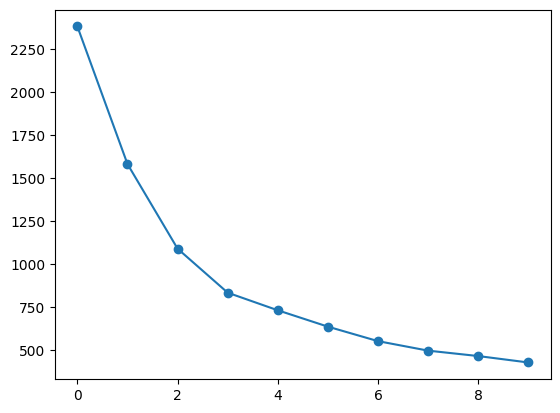

In [18]:
# find the appropriate cluster size for KMeans clustering (a form of unsupervised learning)
inertia = []

for i in np.arange(1,11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

plt.plot(inertia, marker = 'o')

### Appears that the inflexion happens at 3 (i.e. can use n_clusters = 3)

In [19]:
# using n_clusters=3, we re-preform the kmeans clustering & have a look at the first 10 rows
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scaled)
rfm['Clusters'] = (kmeans.labels_) + 1 # adding 1 so that 1st group begins from 1 instead of 0
rfm.head(10)

,Recency,Frequency,Monetary,Clusters
Customer ID,,,,
AA-10315,186,5,5563.560,2
AA-10375,22,9,1056.390,2
AA-10480,261,4,1790.512,2
AA-10645,58,6,5086.935,1
AB-10015,420,3,886.156,3
AB-10060,54,8,7755.620,1
AB-10105,44,10,14473.571,1
AB-10150,46,5,966.710,2
AB-10165,28,8,1113.838,2


In [20]:
# peform further analysis on the different clusters
analysis = rfm.groupby(['Clusters'])['Recency','Frequency','Monetary'].mean()
analysis

,Recency,Frequency,Monetary
Clusters,,,
1,82.607,8.813,5173.595
2,89.917,5.292,1785.569
3,529.652,3.730,1566.943


### From the above analysis, customers belonging to Cluster 1 could be considered as valued customers as they purchased frequently and contributed the most average sales.  Customers in Cluster 2 can be considered as lapsed customers whom do not purchase regularly and have the lowest average sales.  As for customers in Cluster 3, we can probably work on them to move more to Cluster 1, thereby improving sales and probably better inventory turns.

In [21]:
# showing cluster numbers is not information, therefore, convert those cluster numbers to appropriate customers' segments
def classification(row):
    if row['Clusters'] == 1:
        return "Value"
    elif row['Clusters'] == 3:
        return "For Improvement"
    else:
        return "Lapsed"

In [22]:
# show the segmentation in the rfm dataframe
rfm['Class'] = rfm.apply(classification, axis=1)

In [23]:
# have an undertanding of the number of customers in each segement
seg_num = rfm['Class'].value_counts()
seg_num

Lapsed             421
Value              257
For Improvement    115
Name: Class, dtype: int64

In [24]:
# we can also know the proportion of each sgement in our customer base
seg_pct = rfm['Class'].value_counts(normalize=True)
seg_pct

Lapsed             0.531
Value              0.324
For Improvement    0.145
Name: Class, dtype: float64

### As noted above, about 53% of our customers are in the 'For Improvement' segment and we can set out KPIs and collaborative groups (sales, inside sales, customer service, technical service, marketing, etc.) to strategize and plan for this segment. 

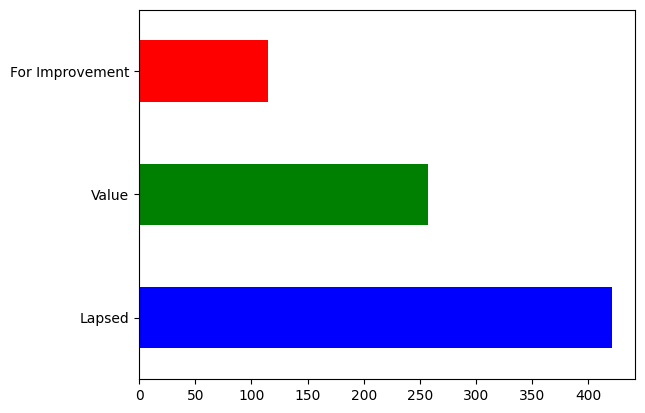

In [25]:
# let's visualize the result
seg_num.plot(kind='barh', color=['blue','green','red'])
plt.show()

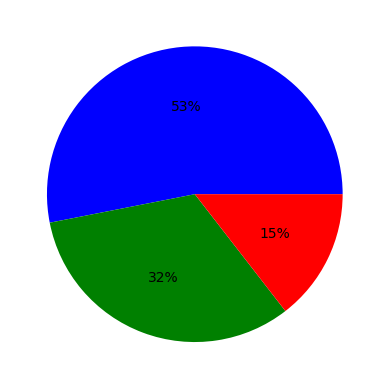

In [26]:
# visualize the proportions using pie chart
palette_color = ['blue','green','red']

plt.pie(seg_pct, colors=palette_color, autopct='%.0f%%')
plt.show()

In [27]:
# let's have a look at the "Value" customers
improve = rfm[rfm['Class'] == 'For Improvement']
improve.sort_values(by=['Monetary'], ascending=False)

,Recency,Frequency,Monetary,Clusters,Class
Customer ID,,,,,
BS-11365,560,5,10501.653,3,For Improvement
PF-19120,835,4,9062.864,3,For Improvement
KD-16270,487,5,8282.358,3,For Improvement
RH-19510,472,6,6979.180,3,For Improvement
VD-21670,581,6,6442.254,3,For Improvement
MC-17425,403,5,4432.138,3,For Improvement
CM-12715,1038,4,3984.452,3,For Improvement
PW-19240,465,7,3922.415,3,For Improvement
JS-15880,537,5,3868.020,3,For Improvement


### With this analysis, we could discuss with management plans to improve the performance of these customers, with the aim of moving a part of them to the 'Value' segment